# Processamento de Linguagem Natural

**Prof. Dr. Hilário Thomaz Alves de Oliveira**  
**Pós-graduação em Desenvolvimento de Aplicações Inteligentes**  
**Processamento de Linguagem Natural — Projeto 01 - Classificação de Decisões Judiciais**  

**Nome:** Otávio Lube dos Santos  
**Matrícula:** 20231DEVAI0157

In [1]:
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install sentencepiece

!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 4.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
from datasets import load_dataset

/Users/otaviolube/Desktop/pos-devai-ifes/6-proc-lig-nat/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset('joelniklaus/brazilian_court_decisions')

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 3234
    })
    validation: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 404
    })
    test: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 405
    })
})

In [5]:
train_texts = dataset['train']['decision_description']
train_labels = dataset['train']['judgment_label']

validation_texts = dataset['validation']['decision_description']
validation_labels = dataset['validation']['judgment_label']

test_texts = dataset['test']['decision_description']
test_labels = dataset['test']['judgment_label']

print(f'\nTrain size: {len(train_texts)} -- {len(train_labels)}')
print(f'Validation size: {len(validation_texts)} -- {len(validation_labels)}')
print(f'Test size: {len(test_texts)} -- {len(test_labels)}')


Train size: 3234 -- 3234
Validation size: 404 -- 404
Test size: 405 -- 405


In [6]:
from collections import Counter

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Validation Labels Distribution: {Counter(validation_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({'no': 1960, 'partial': 677, 'yes': 597})
Validation Labels Distribution: Counter({'no': 221, 'partial': 96, 'yes': 87})
Test Labels Distribution: Counter({'no': 234, 'partial': 93, 'yes': 78})


In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
validation_labels = label_encoder.transform(validation_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Validation Labels Distribution: {Counter(validation_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({np.int64(0): 1960, np.int64(1): 677, np.int64(2): 597})
Validation Labels Distribution: Counter({np.int64(0): 221, np.int64(1): 96, np.int64(2): 87})
Test Labels Distribution: Counter({np.int64(0): 234, np.int64(1): 93, np.int64(2): 78})


In [8]:
import spacy

from tqdm import tqdm

def preprocess_texts(list_texts):
  nlp = spacy.load('pt_core_news_sm', disable=['ner'])
  new_texts = []
  with tqdm(total=len(list_texts), desc='Preprocessing') as pbar:
    for text in list_texts:
      doc = nlp(text)
      tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT'
                and not t.is_stop]
      texto_normalizado = ' '.join(tokens)
      new_texts.append(texto_normalizado)
      pbar.update(1)
  return new_texts

In [9]:
train_texts = preprocess_texts(train_texts)

Preprocessing: 100%|██████████| 3234/3234 [00:15<00:00, 211.07it/s]


In [10]:
validation_texts = preprocess_texts(validation_texts)

Preprocessing: 100%|██████████| 404/404 [00:01<00:00, 202.58it/s]


In [11]:
test_texts = preprocess_texts(test_texts)

Preprocessing: 100%|██████████| 405/405 [00:01<00:00, 203.04it/s]


In [12]:
num_epochs = 3
batch_size = 8
max_len = 512
num_classes = 3

optim = 'adamw_torch'

model_architecture = 'legal_bertimbau_base'

if model_architecture == 'bertimbau_base':
  model_path = 'neuralmind/bert-base-portuguese-cased'
elif model_architecture == 'legal_bertimbau_base':
  model_path = 'rufimelo/Legal-BERTimbau-base'
elif model_architecture == 'legal_bert_pt':
  model_path = 'raquelsilveira/legalbertpt_sc'

print(f'\nModel Architecture: {model_architecture}')


Model Architecture: legal_bertimbau_base


In [13]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_classes)

print(f'Parameters: {model.num_parameters():,}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at rufimelo/Legal-BERTimbau-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameters: 108,925,443


In [14]:
import torch
import torch.nn.functional as f

y_train = torch.tensor(train_labels)
y_val = torch.tensor(validation_labels)
y_test = torch.tensor(test_labels)

y_train = f.one_hot(y_train, num_classes=num_classes)
y_val = f.one_hot(y_val, num_classes=num_classes)
y_test = f.one_hot(y_test, num_classes=num_classes)

y_train

tensor([[0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]])

In [15]:
train_dict = {
    'text': train_texts,
    'label': y_train
}

val_dict = {
    'text': validation_texts,
    'label': y_val
}

test_dict = {
    'text': test_texts,
    'label': y_test
}

In [16]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

In [17]:
def tokenize_text(examples, tokenizer, max_len):
  return tokenizer(examples['text'], padding='max_length', max_length=max_len,
                   truncation=True)

In [18]:
encoded_train_dataset = train_dataset.map(lambda x: tokenize_text(x, tokenizer, max_len), batched=True, batch_size=batch_size)

encoded_val_dataset = val_dataset.map(lambda x: tokenize_text(x, tokenizer, max_len), batched=True, batch_size=batch_size)

encoded_test_dataset = test_dataset.map(lambda x: tokenize_text(x, tokenizer, max_len), batched=True, batch_size=batch_size)

Map: 100%|██████████| 405/405 [00:00<00:00, 1518.45 examples/s]


In [19]:
import numpy as np

from sklearn.metrics import accuracy_score


def compute_classification_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  labels = np.argmax(labels, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'acc': acc
  }

In [20]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(output_dir='training/', logging_strategy='epoch',
                                  optim=optim, logging_steps=10, eval_steps=10,
                                  learning_rate=5e-5, weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=num_epochs, save_strategy='epoch',
                                  load_best_model_at_end=True, metric_for_best_model='acc',
                                  greater_is_better=True, report_to=['none'])

trainer = Trainer(model=model, args=training_args,
                  train_dataset=encoded_train_dataset,
                  eval_dataset=encoded_val_dataset,
                  compute_metrics=compute_classification_metrics,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=2)])

trainer.train()

/Users/otaviolube/Desktop/pos-devai-ifes/6-proc-lig-nat/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Acc
1,0.458100,0.433467,0.722772
2,0.304300,0.432351,0.747525
3,0.192200,0.502359,0.757426


TrainOutput(global_step=1215, training_loss=0.31821558446059994, metrics={'train_runtime': 750.9193, 'train_samples_per_second': 12.92, 'train_steps_per_second': 1.618, 'total_flos': 2552726378797056.0, 'train_loss': 0.31821558446059994, 'epoch': 3.0})

In [21]:
y_pred, _, _ = trainer.predict(encoded_test_dataset)

In [22]:
predicted_labels = np.argmax(y_pred, axis=-1)

predicted_labels

array([2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0,
       0, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1,
       1, 1, 1, 0, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 2, 2, 1, 0, 2, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, 0,
       2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 0, 0,

In [23]:
import pandas as pd
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support

report = classification_report(test_labels, predicted_labels)

print(report)

results_df = pd.DataFrame(columns=['Acurácia', 'Precisão', 'Recall', 'F1-Score'])

accuracy = accuracy_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')

results_df.loc[len(results_df)] = {
    'Acurácia': f'{accuracy * 100:.3f}',
    'Precisão': f'{precision * 100:.3f}',
    'Recall': f'{recall * 100:.3f}',
    'F1-Score': f'{f1 * 100:.3f}'
}

results_df.to_excel(f'resultados_legal_bertimbau_base_{num_epochs}.xlsx', index=False)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       234
           1       0.67      0.69      0.68        93
           2       0.67      0.54      0.60        78

    accuracy                           0.77       405
   macro avg       0.72      0.70      0.71       405
weighted avg       0.77      0.77      0.77       405



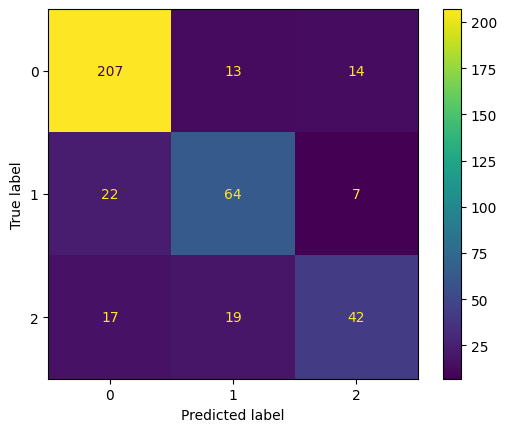

In [24]:
ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels)